<a href="https://colab.research.google.com/github/gagyeomkim/Deep-Learning-Paper-Review-and-Practice/blob/main/code_practice/TextCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Convolutional Neural Networks for Sentence Classification(EMNLP 2014)**
- 본 코드는 TextCNN에 대해서 다룹니다.
    - 본 논문은 자연어 처리 기법의 기본적인 구성을 이해하고 공부하는 데에 도움을 줍니다.
- 코드 실행전에 [런타임] -> [런타임 유형 변경]에서 유형을 GPU로 설정합니다.


- [code by](https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/2-1.TextCNN/TextCNN.ipynb)

### 라이브러리 import

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Code

In [4]:
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.num_filters_total = num_filters * len(filter_sizes)
        self.W = nn.Embedding(vocab_size, embedding_size)   # [vocab_size, embedding_size] 크기의 임베딩행렬 생성
        self.filter_list = nn.ModuleList([nn.Conv2d(1, num_filters, (size, embedding_size)) for size in filter_sizes])
        self.Weight = nn.Linear(self.num_filters_total, num_classes, bias=False)
        self.Bias = nn.Parameter(torch.ones([num_classes])) # [num_classes,] 크기의 element가 1인 tensor 생

    def forward(self, X):
        # X:[batch_size, sequence_length]
        # embedded_chars: [batch_size, sequence_length, embedding_size]
        embedded_chars = self.W(X)
        embedded_chars = embedded_chars.unsqueeze(1)    # add channel(=1) [batch, channel(=1), sequence_length, embedding_size]

        pooled_outputs = []
        for i, conv in enumerate(self.filter_list):
            # conv: [input_channel(=1), output_channel(=3), (filter_height(=window size), filter_width(=embedding_size)),bias option]
            # h: [batch_size(=6), output_channel(=3), output_height(=2), output_width(=1)] <- Convolution 연산 후 공식에 따름
            h = F.relu(conv(embedded_chars))

            # -- maxpooling --
            # mp: ((filter_height, filter_width))
            mp = nn.MaxPool2d((sequence_length - filter_sizes[1] + 1, 1))
            # mp(h): [batch_size(=6), output_channel(=3), output_height(=1), output_width(=1)]
            pooled = mp(h).permute(0, 2, 3, 1) # pooled: [batch_size(=6), output_height(=1), output_width(=1), output_channel(=3)]
            pooled_outputs.append(pooled)

        h_pool = torch.cat(pooled_outputs, len(filter_sizes))   # [batch_size, output_height(=1), output_width(=1), output_channel(=3) * 3]
        h_pool_flat = torch.reshape(h_pool, [-1, self.num_filters_total])   # [batch_size, output_height(=1) * output_width(=1) * (output_channel(=3) * 3)]
        model = self.Weight(h_pool_flat) + self.Bias    # [batch_size, num_classes]
        return model    # 각 클래스에 대한 logits을 반환

if __name__ == '__main__':
    embedding_size = 2  # embedding_size
    sequence_length = 3 # sequence_length
    num_classes = 2 # number of classes
    filter_sizes = [2,2,2]  # n-gram windows
    num_filters = 3 # number of filters

    # 3 words sentences(=sequence_length is 3)
    sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
    labels = [1, 1, 1, 0, 0, 0] # 1 is good, 0 is not good

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    vocab_size = len(word_dict)

    # inputs:[batch_size, seq_length]
    inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])   # 1개의 batch에 대해 word -> index로 변환
    # targets:[batch_size]
    targets = torch.LongTensor([out for out in labels]) # To using Torch Softmax Loss function

    model = TextCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    model.train()
    for epoch in range(5000):
        optimizer.zero_grad()
        output = model(inputs)

        # outputL [batch_size, num_classes], target_batch: [batch_size] (LongTensor, not one-hot)
        loss = criterion(output, targets)
        if (epoch + 1) % 1000 == 0:
            print(f'Epoch: {epoch+1:#04d} cost: {loss:.6f}')

        loss.backward()
        optimizer.step()

    # Test
    model.eval()
    test_text = 'sorry hate you'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]
    test_batch = torch.LongTensor(tests)

    # Predict
    with torch.no_grad():
        output = model(test_batch)
        predict = torch.argmax(output, 1)

    if predict.item() == 0:
        print(test_text, "is Bad Mean...")
    else:
        print(test_text, "is Good mean!!")

Epoch: 1000 cost: 0.002038
Epoch: 2000 cost: 0.000330
Epoch: 3000 cost: 0.000118
Epoch: 4000 cost: 0.000053
Epoch: 5000 cost: 0.000026
sorry hate you is Bad Mean...


### 참고

- asarray의 경우에는 원본이 변경될 경우 asarray의 복사본까지 변경된다. 기본적으로는 np.array()와 동일
- `nn.Conv2d: (input_channel(=1), output_channel(=3), (filter_height, filter_width), bias_option)`
    - filter의 개수 = output_channel 수
    - [파이토치 공식문서](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- `maxPool2d(kernel_size)`: kernel_size 윈도우 내에서 가장 큰 값을 뽑아내는 레이어
    - kernel_size=(sequence_length - filter_sizes[i]+1, 1): pooling을 수행할 window 크기를 설정
        - 즉, 여기서 kernel_size는 컨볼루션(convolution)의 학습 가능한 필터(filter)가 아니라, **최댓값을 찾을 영역을 지정하는 단순한 윈도우(window) 크기**
- 마지막 차원(채널)에 대해 합치면, 다른 차원들은 그대로 유지되고 마지막 차원의 크기만 더해짐
→ [6, 1, 1, 9]
```python
# for 루프가 끝난 후의 pooled_outputs
[
    tensor_from_filter_1,  # 첫 번째 필터 그룹의 결과 (shape: [6, 1, 1, 3])
    tensor_from_filter_2,  # 두 번째 필터 그룹의 결과 (shape: [6, 1, 1, 3])
    tensor_from_filter_3   # 세 번째 필터 그룹의 결과 (shape: [6, 1, 1, 3])
]
```
    - 이때, pooled_outputs를 5차원이라고 하지는 않는다.. 그냥 텐서들을 담아둔 리스트로 취급함
    - 아래 ref의 코드를 살펴보면, [x,y]의 부분을 미리 만들어준 것이라고 생각하면 됨  
    https://sanghyu.tistory.com/85
- permute: 차원 간의 순서를 바꿔줄 때 쓰는 함수.
    - 아래와 같이, permute 안에 들어오는 인자에 기존에 있던 축을 어떤 순으로 다시 배열할지 알려주면 됨. -> (기존축2, 기존축0, 기존축1)
```python
x = torch.randn(2, 3, 5)
x.size()
torch.permute(x, (2, 0, 1)).size()
```
    - x.permute(0, 2, 1) 라고 하면:
        - 새로운 0번 축 위치에 기존 0번 축을 가져온다.
        - 새로운 1번 축 위치에 기존 2번 축을 가져온다.
        - 새로운 2번 축 위치에 기존 1번 축을 가져온다.

- nn.Embedding은 각 단어들에 대한 embedding table을 만들어주는 역할로,  nn.Embedding의 1번째 인자는 input의 shape이랑은 전혀 관련이 없음
    - 음 W의 shape의 마지막 차원에 왜 embedding_dim이 있는지 궁금했어.-> 이거는 sentence의 각 token마다 어떤 embedding을 가지고 있는지를 말해주기 위해서임

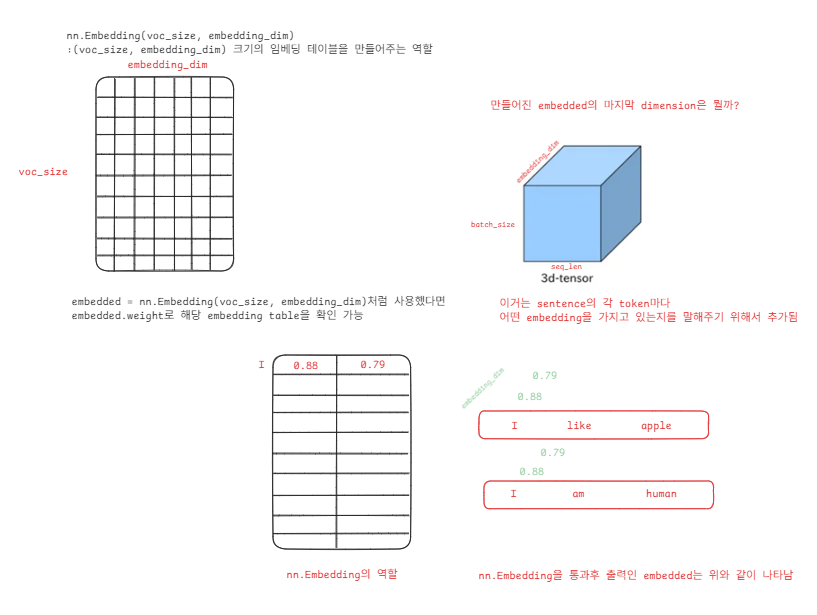

- torch.reshape: 바꾸고 싶은 새로운 모양을 리스트나 튜플의 형태로 두번째 인자로  받음

#### code test

In [ ]:
for sen in sentences:
    # sentence에서 단어마다 자르고, word2index
    print([word_dict[n] for n in sen.split()])
    print('-'*30)
    # asarray의 경우에는 원본이 변경될 경우 asarray의 복사본까지 변경된다. 기본적으로는 np.array()와 동일
    print(np.array([word_dict[n] for n in sen.split()]))
    print(np.asarray([word_dict[n] for n in sen.split()]))
    print('\n')

[3, 2, 4]
------------------------------
[3 2 4]
[3 2 4]


[11, 12, 9]
------------------------------
[11 12  9]
[11 12  9]


[1, 13, 5]
------------------------------
[ 1 13  5]
[ 1 13  5]


[3, 14, 4]
------------------------------
[ 3 14  4]
[ 3 14  4]


[6, 10, 0]
------------------------------
[ 6 10  0]
[ 6 10  0]


[7, 15, 8]
------------------------------
[ 7 15  8]
[ 7 15  8]




In [ ]:
print(inputs.shape)
W = nn.Embedding(16, 2) # (voc_size, embedding_dim) # 각 단어들에 대해서, embedding table을 만들어주는 역할
                        # 전체 모델이 알아야 할 단어 수가 16개이기 때문에 16을 적어주는 것. nn.Embedding의 1번째 인자는 input의 shape이랑은 전혀 관련이 없음
embedded_chars = W(inputs)  # [batch_size, sequence_length, embedding_size]
print(embedded_chars)
print(W.weight.shape)
embedded_chars.shape


torch.Size([6, 3])
tensor([[[-1.1155, -1.2827],
         [ 0.0085, -0.6874],
         [ 0.2616,  0.0801]],

        [[-0.0410,  0.1573],
         [-0.1963,  0.8394],
         [ 1.2813,  0.5607]],

        [[-0.4360, -1.5218],
         [-1.4194, -1.1292],
         [ 0.0843, -2.1578]],

        [[-1.1155, -1.2827],
         [ 1.3926,  0.6705],
         [ 0.2616,  0.0801]],

        [[-2.0893, -0.2336],
         [-1.0888, -0.0652],
         [-1.6868,  0.5357]],

        [[-0.0948, -0.4378],
         [-1.3052, -0.6929],
         [-0.6767, -1.2393]]], grad_fn=<EmbeddingBackward0>)
torch.Size([16, 2])


torch.Size([6, 3, 2])

In [ ]:
torch.ones([num_classes])

tensor([1., 1.])

In [ ]:
# nn,Embedding(num_embeddings, embedding_dim)
# 1) num_embeddings : 임베딩 사전 개수 (즉 몇 개의 임베딩을 만들 것인지 -> 보통 vocabulary size만큼 임베딩 만듦)
# 2) embedding_dim : 임베딩 차원 크기(만들 임베딩의 dimension 크기)

W = nn.Embedding(vocab_size, embedding_size)
embedded = W(inputs)
print(embedded)
embedded.shape

tensor([[[-0.1416,  1.6229],
         [-0.5499,  0.2918],
         [-0.2858,  0.3057]],

        [[ 1.1496,  0.3799],
         [-0.6313,  0.7417],
         [-0.6523,  0.2393]],

        [[-1.0552,  0.2596],
         [-0.0486,  3.7038],
         [ 0.1138, -0.7443]],

        [[-0.1416,  1.6229],
         [-0.7778, -0.3503],
         [-0.2858,  0.3057]],

        [[-0.9204, -0.4786],
         [-0.0932, -1.8306],
         [ 0.5776, -0.8236]],

        [[ 0.6608,  0.0487],
         [ 0.1020,  0.6199],
         [ 0.6151, -0.0109]]], grad_fn=<EmbeddingBackward0>)


torch.Size([6, 3, 2])